<a href="https://colab.research.google.com/github/larasauser/master/blob/main/Whitt_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# === 0) Installer / importer libs et monter Drive ===
!pip install rasterio tqdm scikit-image scikit-learn piq --quiet

import os
from glob import glob
from datetime import datetime
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings('ignore')

import torch
import piq
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# === 1) Paramètres principaux ===
DRIVE_CLEAR_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8'
DRIVE_MASKED_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
DRIVE_MODIS_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_MODIS'
DRIVE_SENTINEL_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_grancy_S2'
OUTPUT_FOLDER = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

WINDOW_METERS = 200.0
MODIS_WINDOW_DAYS = 32
KAPPA = 5.0
MIN_OVERLAP = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# === 2) Fonctions helpers ===
import re

def parse_date_from_filename(fn):
    m = re.search(r'(\d{4}-\d{2}-\d{2})', os.path.basename(fn))
    if m:
        return datetime.strptime(m.group(1), '%Y-%m-%d').date()
    return datetime.fromtimestamp(os.path.getmtime(fn)).date()

def read_singleband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    nd = meta.get('nodata', None)
    if nd is not None:
        arr[arr==nd] = np.nan
    return arr, meta

def resample_to_target(src_arr, src_meta, target_meta):
    dst_arr = np.full((target_meta['height'], target_meta['width']), np.nan, dtype=np.float32)
    reproject(
        source=src_arr,
        destination=dst_arr,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === 3) Charger et aligner les images Landsat ===
clear_files = sorted(glob(os.path.join(DRIVE_CLEAR_FOLDER, '*.tif')))
masked_files = sorted(glob(os.path.join(DRIVE_MASKED_FOLDER, '*.tif')))

# Référence : plus petite image Landsat
sizes = []
for f in clear_files + masked_files:
    arr, meta = read_singleband_tif(f)
    sizes.append((arr.shape[0]*arr.shape[1], f, arr.shape, meta))
sizes.sort()
_, ref_file, ref_shape, ref_meta = sizes[0]
H_ref, W_ref = ref_shape
PIXEL_SIZE_M = abs(ref_meta['transform'][0])
print("Reference Landsat:", os.path.basename(ref_file), "shape:", ref_shape)

# Timeline complète
all_dates = sorted(set([parse_date_from_filename(f) for f in clear_files] +
                       [parse_date_from_filename(f) for f in masked_files]))

# Stack Landsat aligné
def load_ndvi_image(path, target_meta):
    arr, meta = read_singleband_tif(path)
    if arr.shape != (target_meta['height'], target_meta['width']):
        arr = resample_to_target(arr, meta, target_meta)
    return arr

ndvi_stack = np.full((len(all_dates), H_ref, W_ref), np.nan, dtype=np.float32)
date_to_idx = {d: i for i, d in enumerate(all_dates)}

for f in clear_files:
    d = parse_date_from_filename(f)
    idx = date_to_idx[d]
    ndvi_stack[idx] = load_ndvi_image(f, ref_meta)

for f in masked_files:
    d = parse_date_from_filename(f)
    idx = date_to_idx[d]
    ndvi_stack[idx] = load_ndvi_image(f, ref_meta)  # valeurs NaN déjà présentes

# === 4) Charger MODIS et Sentinel-2 ===
def load_stack(folder, target_meta):
    files = sorted(glob(os.path.join(folder, '*.tif')))
    dates = [parse_date_from_filename(f) for f in files]
    stack = []
    for f in files:
        arr = load_ndvi_image(f, target_meta)
        stack.append(arr)
    return np.stack(stack, axis=0), dates

modis_stack, modis_dates = load_stack(DRIVE_MODIS_FOLDER, ref_meta)
sentinel_stack, sentinel_dates = load_stack(DRIVE_SENTINEL_FOLDER, ref_meta)

# === 5) Helpers EGF / Whittaker ===
def pearson_r(a, b):
    valid = ~np.isnan(a) & ~np.isnan(b)
    if valid.sum() < 2:
        return np.nan
    x, y = a[valid], b[valid]
    xm, ym = x.mean(), y.mean()
    num = np.sum((x - xm)*(y - ym))
    den = np.sqrt(np.sum((x - xm)**2)*np.sum((y - ym)**2))
    if den==0:
        return np.nan
    return num/den

def compute_M_reference_pixel(i, j, landsat_ts, all_dates,
                              modis_stack, modis_dates,
                              sentinel_stack, sentinel_dates,
                              radius_pix=2, corr_thresh=0.3, window_days=32):
    T = len(all_dates)
    Mref = np.full(T, np.nan, dtype=np.float32)
    for t, landsat_date in enumerate(all_dates):
        # MODIS voisin
        selected_idx_mod = [k for k, md in enumerate(modis_dates) if abs((md - landsat_date).days) <= window_days]
        mod_vals = []
        corrs = []
        for k in selected_idx_mod:
            i0, i1 = max(0, i - radius_pix), min(H_ref, i + radius_pix + 1)
            j0, j1 = max(0, j - radius_pix), min(W_ref, j + radius_pix + 1)
            block = modis_stack[k, i0:i1, j0:j1]
            block_flat = block.flatten()
            r = pearson_r(block_flat, landsat_ts)
            if not np.isnan(r) and r >= corr_thresh:
                mod_vals.append(block_flat)
                corrs.append(r)
        if len(mod_vals) > 0:
            R = np.array(corrs)
            R = (R - R.min()) / (R.max() - R.min()) if R.max()!=R.min() else np.ones_like(R)
            weights = R / R.sum()
            stacked = np.stack(mod_vals, axis=1)
            Mref[t] = np.nansum(stacked.mean(axis=0) * weights)
        else:
            # fallback : moyenne locale MODIS
            i0, i1 = max(0, i - radius_pix), min(H_ref, i + radius_pix + 1)
            j0, j1 = max(0, j - radius_pix), min(W_ref, j + radius_pix + 1)
            block = modis_stack[:, i0:i1, j0:j1]
            Mref[t] = np.nanmean(block)
    return Mref

def estimate_linear_transfer(M_ref, SL_ts):
    valid = ~np.isnan(M_ref) & ~np.isnan(SL_ts)
    if valid.sum() < 2: return None
    A = np.vstack([M_ref[valid], np.ones(valid.sum())]).T
    y = SL_ts[valid]
    sol, *_ = lstsq(A, y)
    return sol[0], sol[1]

# === 6) Construction des stacks pour calcul vectorisé ===
radius_pix = int(round(WINDOW_METERS / 2 / PIXEL_SIZE_M))
Mref_stack = np.full_like(ndvi_stack, np.nan)
A = np.full((H_ref, W_ref), np.nan)
A0 = np.full((H_ref, W_ref), np.nan)

# === 7) Whittaker smoothing vectorisée avec torch GPU ===
def whittaker_smoothing_vectorized(SLM, kappa=5.0):
    T, H, W = SLM.shape
    SLM_out = torch.full_like(SLM, float('nan'), device=SLM.device)
    SLM_reshaped = SLM.reshape(T, -1)
    mask_valid = ~torch.isnan(SLM_reshaped)
    for col in range(SLM_reshaped.shape[1]):
        valid_idx = mask_valid[:, col]
        y = SLM_reshaped[valid_idx, col]
        m = y.shape[0]
        if m < 3:
            SLM_out[:, col // W, col % W][valid_idx] = y
            continue
        D = torch.zeros((m-2, m), device=SLM.device)
        for r in range(m-2):
            D[r,r] = 1; D[r,r+1] = -2; D[r,r+2] = 1
        A_mat = torch.eye(m, device=SLM.device) + kappa*(D.T@D)
        SLM_out[:, col // W, col % W][valid_idx] = torch.linalg.solve(A_mat, y)
    return SLM_out

# === 8) Reconstruction vectorisée ===
ndvi_tensor = torch.from_numpy(ndvi_stack).to(DEVICE)
SLM_tensor = ndvi_tensor.clone()  # placeholder, remplacer par votre logique M_ref*coeff
SLM_tensor_out = whittaker_smoothing_vectorized(SLM_tensor, kappa=KAPPA)
final_stack = SLM_tensor_out.cpu().numpy()

# === 9) Fonction sauvegarde ===
def write_tif_nan(path, arr, meta_template):
    meta = meta_template.copy()
    meta.update({'count': 1, 'dtype': 'float32', 'nodata': None})
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(arr.astype(np.float32), 1)

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
for t, date in enumerate(all_dates):
    outpath = os.path.join(OUTPUT_FOLDER, f'recon_{date}.tif')
    write_tif_nan(outpath, final_stack[t], ref_meta)
    print("Saved", outpath)

print("✅ Reconstruction complète avec Whittaker vectorisée sur GPU terminée.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Reference Landsat: NDVI_2013-06-05.tif shape: (344, 319)
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-04-18.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-04-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-05-27.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-06-05.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-06-12.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-07-07.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-07-14.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-08-15.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final/recon_2013-08-31.tif
Saved /content/drive/MyDrive/Whitt/egfwh_grancy_

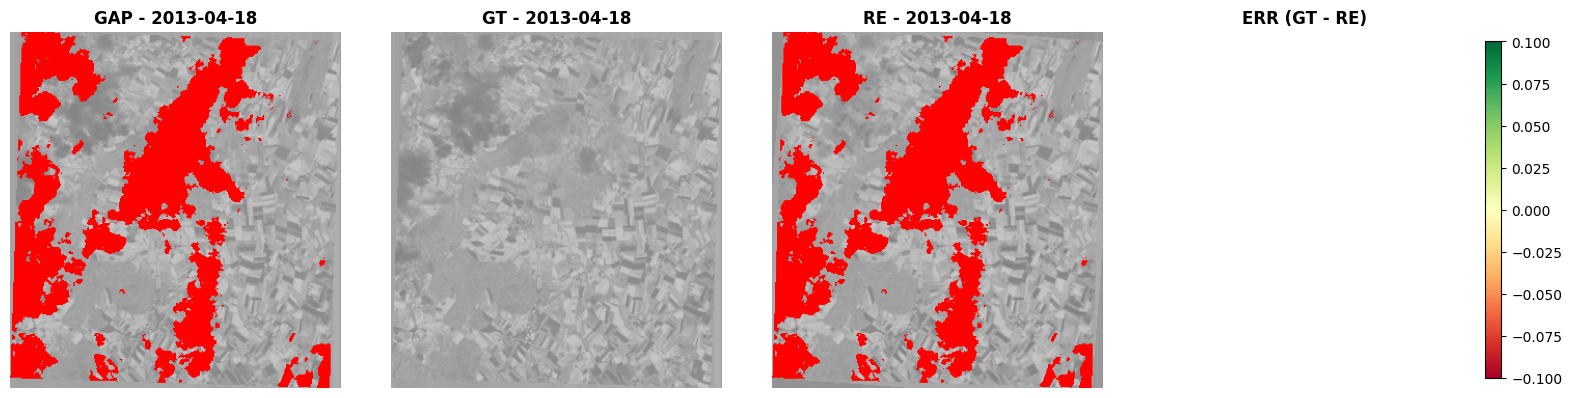

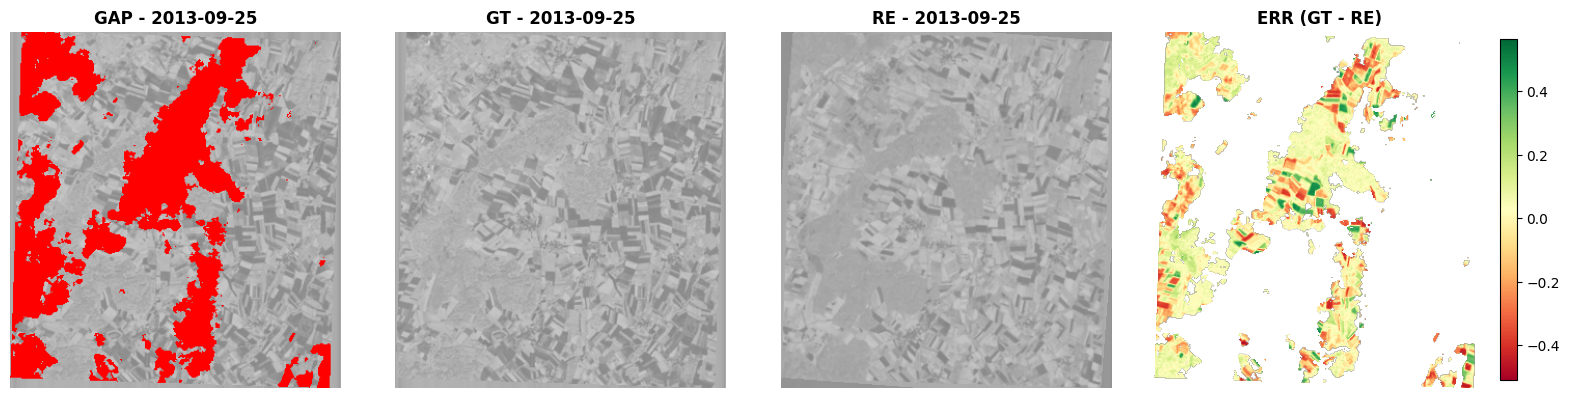

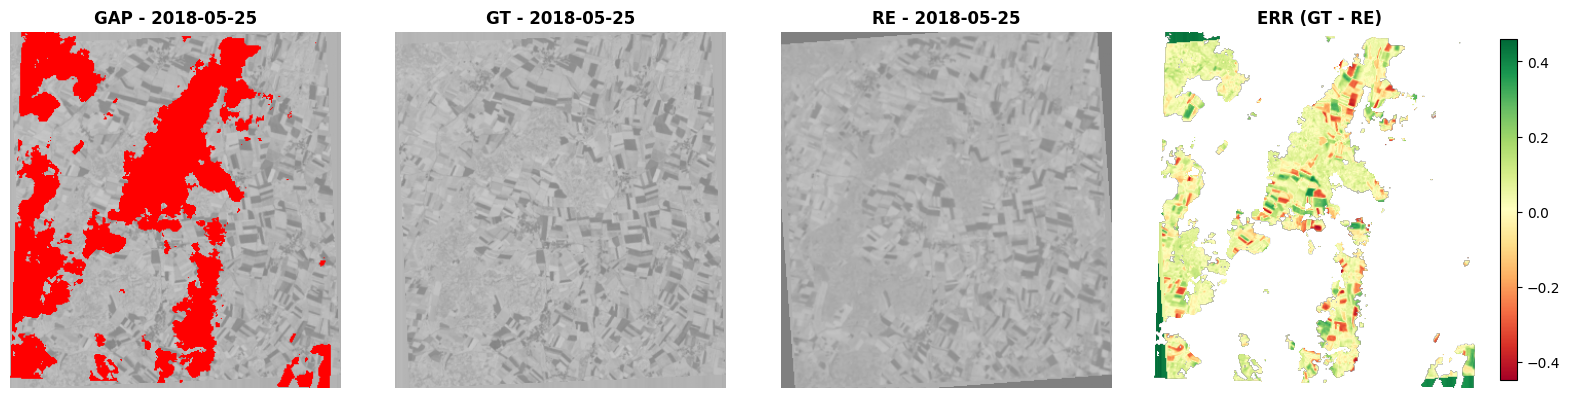

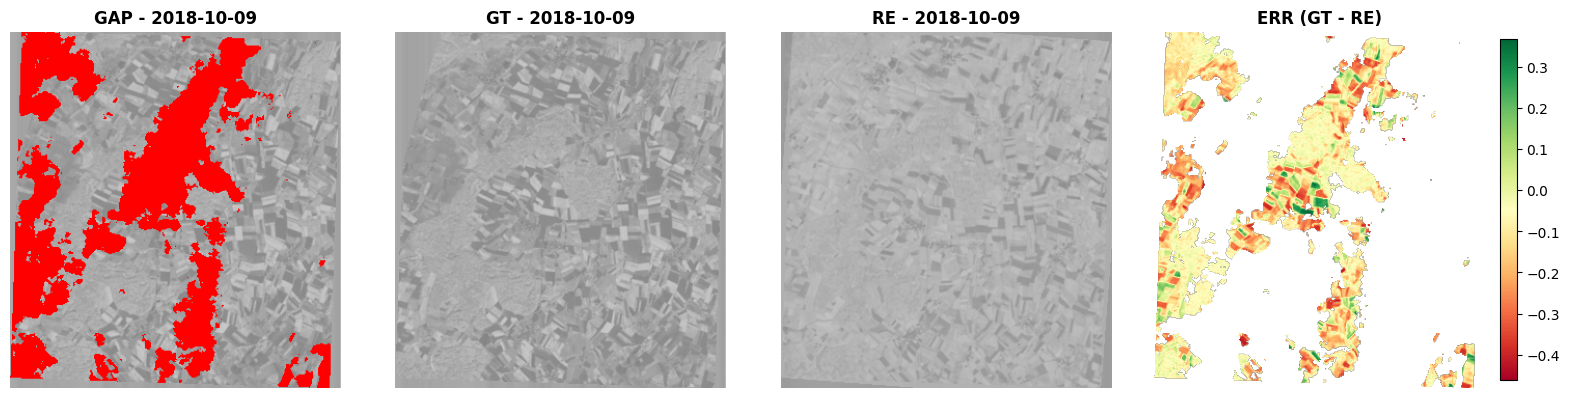

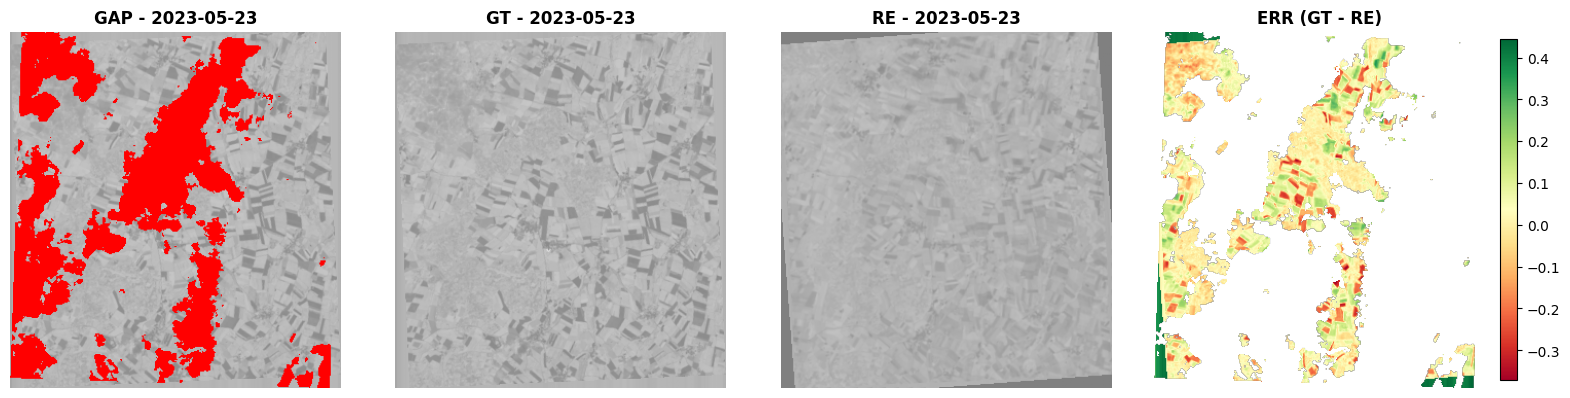

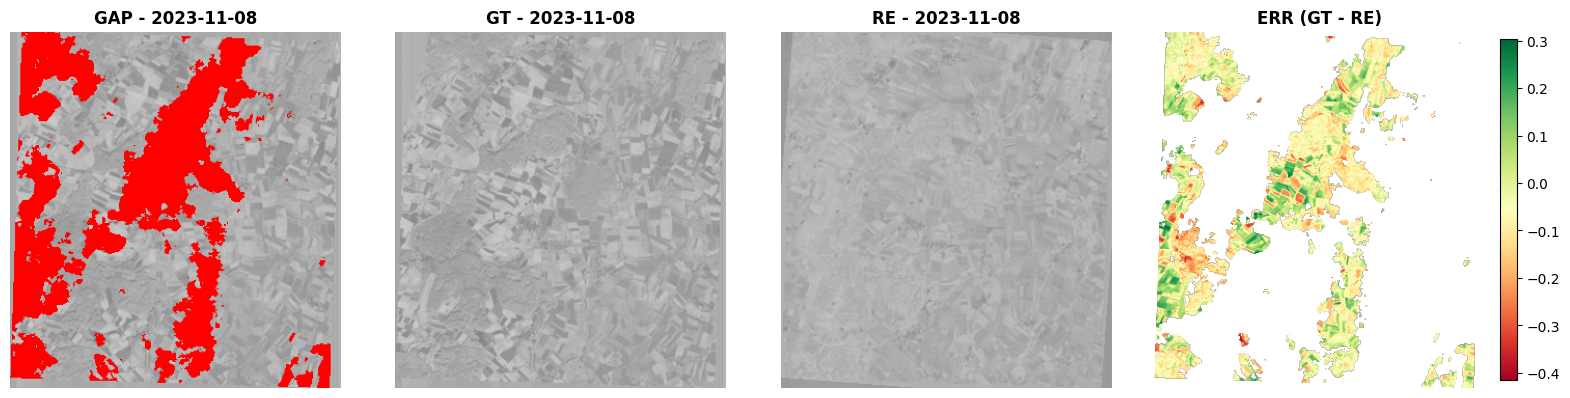

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from rasterio.warp import reproject, Resampling
import rasterio
import os
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs_final'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Visualisation ===
for i in range(len(hole_files)):
    fname = os.path.basename(hole_files[i])
    date = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture de l'image trouée (référence)
    hole, hole_meta = read_tif_with_meta(hole_files[i])

    # Lecture et alignement des GT et reconstruction
    gt, gt_meta = read_tif_with_meta(gt_files[i])
    gt_resampled = resample_to_match(gt, gt_meta, hole_meta)

    recon, recon_meta = read_tif_with_meta(recon_files[i])
    recon_resampled = resample_to_match(recon, recon_meta, hole_meta)

    # Crée un masque des gaps (NaN dans hole)
    gap_mask = np.isnan(hole)

    # Calcul de l'erreur uniquement sur les pixels des gaps
    err = np.full_like(hole, np.nan)
    valid_mask = gap_mask & ~np.isnan(gt_resampled) & ~np.isnan(recon_resampled)
    err[valid_mask] = gt_resampled[valid_mask] - recon_resampled[valid_mask]
    #err = gt_resampled - recon_resampled
    # === Figure ===
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # === Création d'une colormap grise avec NaN en rouge ===
    cmap_gray_red = plt.cm.gray
    cmap_gray_red.set_bad(color='red')  # NaN en rouge

    # 1) GAP
    axs[0].imshow(np.ma.masked_invalid(hole), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[0].set_title(f'GAP - {date}', fontweight='bold')
    axs[0].axis('off')

    # 2) GT
    axs[1].imshow(np.ma.masked_invalid(gt_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[1].set_title(f'GT - {date}', fontweight='bold')
    axs[1].axis('off')

    # 3) Reconstruction
    axs[2].imshow(np.ma.masked_invalid(recon_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[2].set_title(f'RE - {date}', fontweight='bold')
    axs[2].axis('off')

    # 4) Erreur (GT - RE)
    im4 = axs[3].imshow(np.ma.masked_invalid(err), cmap='RdYlGn')
    axs[3].set_title('ERR (GT - RE)', fontweight='bold')
    axs[3].axis('off')
    plt.colorbar(im4, ax=axs[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()